In [32]:
!pip install openeo -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.9/315.9 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.8/206.8 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 57.2 MB/s eta 0:00:00


In [15]:

# --- Step 1: Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler


In [33]:
import openeo


# Connect to an openEO backend (VITO public backend)
conn = openeo.connect("https://openeo.dataspace.copernicus.eu").authenticate_oidc()


# Define bounding box (lat/lon) and date range
bbox = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              100.06885131321991,
              15.191613217686992
            ],
            [
              100.06885131321991,
              15.185366640008795
            ],
            [
              100.0769259128906,
              15.185366640008795
            ],
            [
              100.0769259128906,
              15.191613217686992
            ],
            [
              100.06885131321991,
              15.191613217686992
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}
start_date = "2017-01-01"
end_date = "2024-12-31"


# Load Sentinel-2 data cube
s2 = conn.load_collection(
"SENTINEL2_L2A",
spatial_extent=bbox,
temporal_extent=[start_date, end_date],
bands=["B04", "B08"]
)


# Compute NDVI: (B08 - B04) / (B08 + B04)
ndvi = (s2.band("B08") - s2.band("B04")) / (s2.band("B08") + s2.band("B04"))


# Aggregate NDVI by date
ndvi_ts = ndvi.aggregate_temporal_period(reducer="mean", period="dekad")
ndvi_ts = ndvi_ts.aggregate_spatial(geometries=bbox,reducer='mean')

# Download as JSON and convert to DataFrame
ndvi_ts.execute_batch(title='ndvi_timeseries',filename="timeseries.json")

Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=JTDM-VQIL 📋 to authenticate.

✅ Authorized successfully

Authenticated using device code flow.
0:00:00 Job 'j-2508221436464186a7c909457e2b0845': send 'start'
0:00:14 Job 'j-2508221436464186a7c909457e2b0845': created (progress 0%)
0:00:19 Job 'j-2508221436464186a7c909457e2b0845': created (progress 0%)
0:00:26 Job 'j-2508221436464186a7c909457e2b0845': running (progress N/A)
0:00:34 Job 'j-2508221436464186a7c909457e2b0845': running (progress N/A)
0:00:44 Job 'j-2508221436464186a7c909457e2b0845': running (progress N/A)
0:00:56 Job 'j-2508221436464186a7c909457e2b0845': running (progress N/A)
0:01:12 Job 'j-2508221436464186a7c909457e2b0845': running (progress N/A)
0:01:31 Job 'j-2508221436464186a7c909457e2b0845': running (progress N/A)
0:01:55 Job 'j-2508221436464186a7c909457e2b0845': running (progress N/A)
0:02:26 Job 'j-2508221436464186a7c909457e2b0845': running (progress N/A)
0:03:04 Job 'j-2508221436464186a7c909457e2b0845': running (progress N/A)
0:03:51 Job 'j-2508221436464186a7c909457e2b0845': running (progress N/A)
0:04:49 Job 'j-2508221436

<BatchJob job_id='j-2508221436464186a7c909457e2b0845'>

In [40]:
import pandas as pd
df = pd.read_json("timeseries.json")
df = df.T.reset_index()
df.columns = ["date", "ndvi"]
df["ndvi"] = df["ndvi"].apply(lambda x: x[0] if isinstance(x, list) else x)
print(df.head())

                       date      ndvi
0 2017-05-01 00:00:00+00:00  0.037972
1 2017-12-11 00:00:00+00:00  0.349277
2 2018-12-11 00:00:00+00:00  0.197968
3 2022-04-11 00:00:00+00:00  0.249769
4 2022-10-11 00:00:00+00:00  0.365375


In [52]:
# Scale data for RNN
scaler = MinMaxScaler()
df['ndvi_scaled'] = scaler.fit_transform(df[['ndvi']])

# Create sequences for supervised learning
def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LEN = 2
X, y = create_sequences(df['ndvi_scaled'].values, SEQ_LEN)
X = np.nan_to_num(X)
y = np.nan_to_num(y)
# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("Training samples:", X_train.shape)


Training samples: (228, 2)


In [53]:

# --- Step 4: Build GRU Model ---
model = Sequential([
    GRU(64, return_sequences=True, input_shape=(SEQ_LEN, 1)),
    Dropout(0.2),
    GRU(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_8 (GRU)                     │ (None, 2, 64)          │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_9 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,305 (87.13 KB)

 Trainable params: 22,305 (87.13 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:

# Reshape for GRU [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], SEQ_LEN, 1))
X_test = X_test.reshape((X_test.shape[0], SEQ_LEN, 1))

# --- Step 5: Train Model ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32
)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.2559 - val_loss: 0.1018
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0975 - val_loss: 0.0495
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0605 - val_loss: 0.0556
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0694 - val_loss: 0.0500
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0599 - val_loss: 0.0487
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0569 - val_loss: 0.0485
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0592 - val_loss: 0.0483
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0594 - val_loss: 0.0482
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0545 - val_loss: 0.0482
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0596 - val_loss: 0.0476


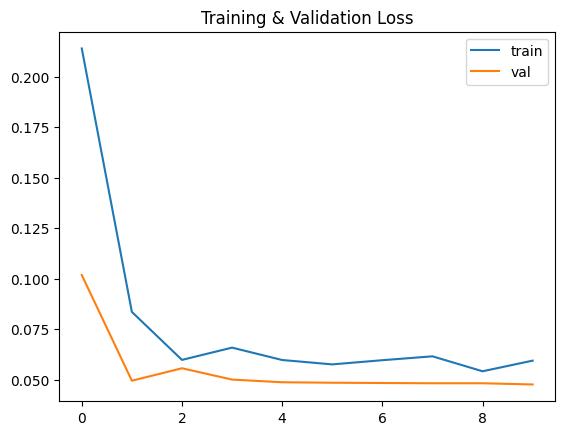

In [55]:

# Plot training loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.title("Training & Validation Loss")
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


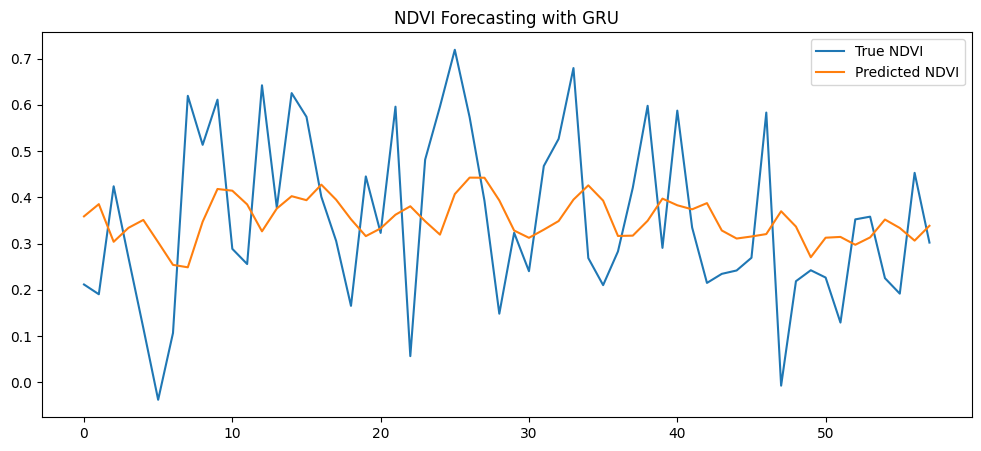

In [56]:

# --- Step 6: Evaluate Model ---
y_pred = model.predict(X_test)

# Inverse scale predictions
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1,1))

plt.figure(figsize=(12,5))
plt.plot(y_test_rescaled, label='True NDVI')
plt.plot(y_pred_rescaled, label='Predicted NDVI')
plt.legend()
plt.title("NDVI Forecasting with GRU")
plt.show()
